# 快速DEM插值方法演示

本notebook演示了几种高效的DEM插值方法，特别适用于原始数据分辨率远高于目标分辨率的情况。

## 可用的插值方法：
1. **vectorized** - 向量化最邻近插值（推荐，最快）
2. **fast_nearest** - 快速最邻近插值
3. **block_average** - 块平均插值
4. **nearest** - 传统最邻近插值
5. **linear** - 传统线性插值（最慢但最平滑）


In [1]:
import sys
sys.path.append('..')

from src.dem_interpolation import *
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


## 1. 加载原始DEM数据


In [2]:
# DEM文件路径
dem_file_path = r'h:\data\DEM\ASTGTM2_N23E111_dem.tif'

# 加载DEM数据
dem_data = load_dem_data(dem_file_path)

if dem_data is not None:
    print("\n原始数据信息:")
    print(f"数据形状: {dem_data.shape}")
    print(f"数据大小: {dem_data.nbytes / 1024 / 1024:.2f} MB")
    print(f"经度范围: {dem_data.x.min().values:.4f}° - {dem_data.x.max().values:.4f}°")
    print(f"纬度范围: {dem_data.y.min().values:.4f}° - {dem_data.y.max().values:.4f}°")
    
    # 计算原始分辨率
    x_res = abs(dem_data.x.values[1] - dem_data.x.values[0])
    y_res = abs(dem_data.y.values[1] - dem_data.y.values[0])
    print(f"原始分辨率: {x_res:.6f}° × {y_res:.6f}° (约 {x_res*111000:.0f}m × {y_res*111000:.0f}m)")


DEM数据已成功加载:
数据形状: (1, 3601, 3601)
数据大小: 24.73 MB

原始数据信息:
数据形状: (1, 3601, 3601)
数据大小: 24.73 MB
经度范围: 111.0000° - 112.0000°
纬度范围: 23.0000° - 24.0000°
原始分辨率: 0.000278° × 0.000278° (约 31m × 31m)


## 2. 性能比较测试 - 直接使用推荐的快速方法


In [3]:
# 创建目标网格 (0.01°×0.01°，约1km分辨率)
lon_grid, lat_grid = create_target_grid(dem_data, resolution=0.01)

print(f"\n分辨率对比:")
print(f"原始分辨率: ~{x_res*111000:.0f}m")
print(f"目标分辨率: ~{0.01*111000:.0f}m")
print(f"降采样比例: {0.01/x_res:.1f}:1")

# 使用向量化方法（最快推荐）
print("\n使用推荐的向量化方法进行插值...")
interpolated_dem = interpolate_dem_to_grid(dem_data, lon_grid, lat_grid, method='vectorized')


目标网格信息:
经度范围: 110.9999° - 112.0099°
纬度范围: 22.9999° - 24.0099°
网格大小: 102 × 102
网格分辨率: 0.01°

分辨率对比:
原始分辨率: ~31m
目标分辨率: ~1110m
降采样比例: 36.0:1

使用推荐的向量化方法进行插值...
使用向量化插值方法（推荐）...
插值完成! 耗时: 0.19秒
插值后数据大小: 0.08 MB
数据压缩比: 311.59


## 3. 可视化对比（使用统一地理坐标）



=== 数据对比统计 ===
原始数据: 最小值=-150.0m, 最大值=1287.0m, 平均值=201.5m
插值数据: 最小值=-47.0m, 最大值=1168.0m, 平均值=201.7m
高程范围: -150.0m - 1287.0m
对比图已保存到: fast_dem_comparison.png


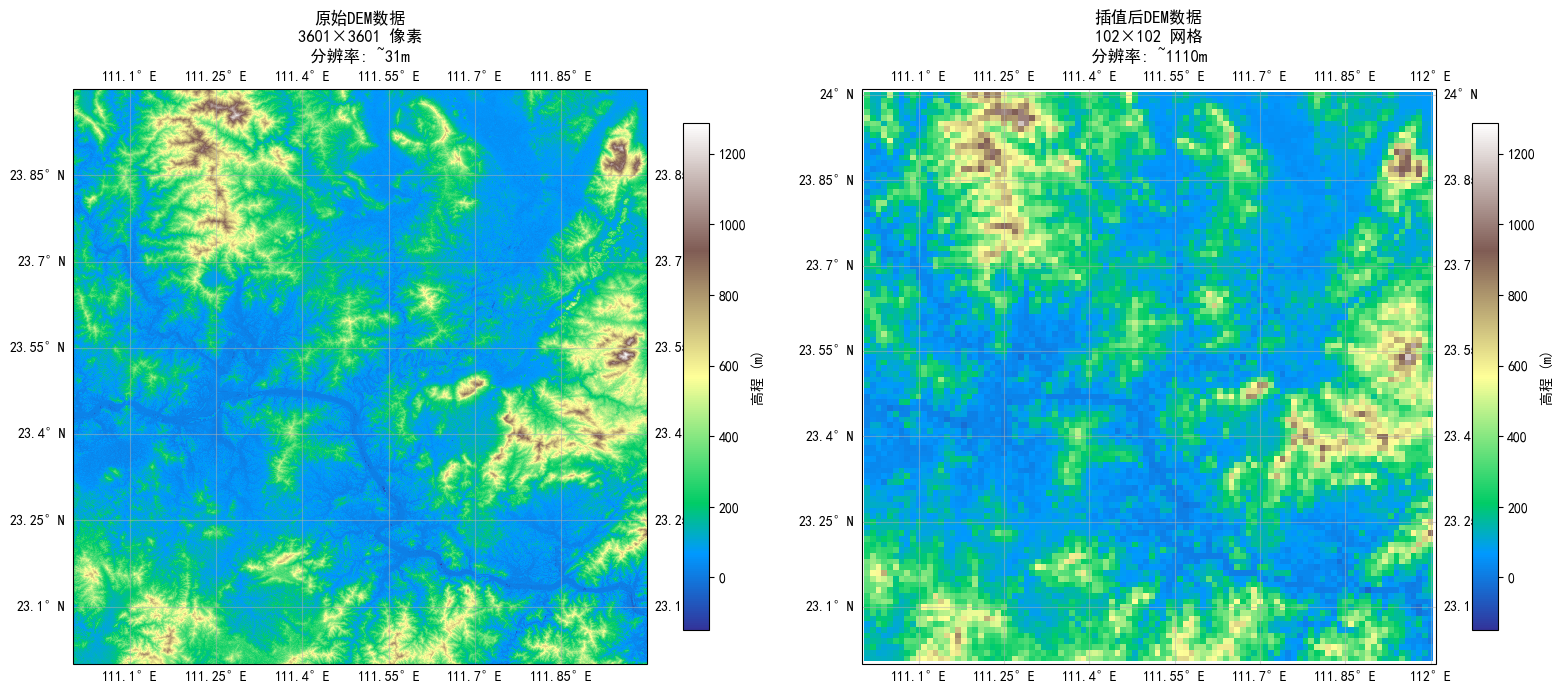

In [4]:
# 可视化原始数据和插值后的数据对比
# 使用cartopy统一绘制地理信息，确保坐标轴一致
visualize_comparison(dem_data, interpolated_dem, save_path='fast_dem_comparison.png')


## 4. 多种方法性能和质量对比


In [5]:
# 比较不同插值方法的性能和质量
methods_to_test = ['vectorized', 'fast_nearest', 'nearest']  # 只测试快速方法
interpolated_results = {}
performance_stats = {}

print("=== 快速插值方法对比测试 ===")
for method in methods_to_test:
    print(f"\n测试方法: {method}")
    start_time = time.time()
    
    try:
        result = interpolate_dem_to_grid(dem_data, lon_grid, lat_grid, method=method)
        elapsed_time = time.time() - start_time
        
        interpolated_results[method] = result
        performance_stats[method] = {
            'time': elapsed_time,
            'min': result.min().values,
            'max': result.max().values,
            'mean': result.mean().values,
            'std': result.std().values
        }
        
        print(f"✓ 完成! 耗时: {elapsed_time:.2f}秒")
        
    except Exception as e:
        print(f"✗ 失败: {str(e)}")

# 显示性能统计
print("\n" + "="*60)
print("方法性能对比:")
print("-"*60)

if performance_stats:
    fastest_time = min([stats['time'] for stats in performance_stats.values()])
    
    for method, stats in performance_stats.items():
        speedup = fastest_time / stats['time'] if stats['time'] > 0 else 1
        print(f"{method:12} | {stats['time']:6.2f}秒 | {speedup:4.1f}x | "
              f"平均高程: {stats['mean']:6.1f}m | 标准差: {stats['std']:5.1f}m")
    
    print("-"*60)
    print(f"推荐使用: vectorized (通常最快且质量好)")


=== 快速插值方法对比测试 ===

测试方法: vectorized
使用向量化插值方法（推荐）...
插值完成! 耗时: 0.12秒
插值后数据大小: 0.08 MB
数据压缩比: 311.59
✓ 完成! 耗时: 0.12秒

测试方法: fast_nearest
使用快速最邻近插值方法...
插值完成! 耗时: 0.02秒
插值后数据大小: 0.08 MB
数据压缩比: 311.59
✓ 完成! 耗时: 0.02秒

测试方法: nearest
使用传统插值方法: nearest...
原始数据点数: 12967201
目标网格点数: 10404
插值完成! 耗时: 4.06秒
插值后数据大小: 0.08 MB
数据压缩比: 311.59
✓ 完成! 耗时: 4.09秒

方法性能对比:
------------------------------------------------------------
vectorized   |   0.12秒 |  0.2x | 平均高程:  201.7m | 标准差: 168.0m
fast_nearest |   0.02秒 |  1.0x | 平均高程:    nanm | 标准差:   nanm
nearest      |   4.09秒 |  0.0x | 平均高程:  202.9m | 标准差: 167.9m
------------------------------------------------------------
推荐使用: vectorized (通常最快且质量好)



绘制多方法对比图...
多方法对比图已保存到: multi_method_comparison.png


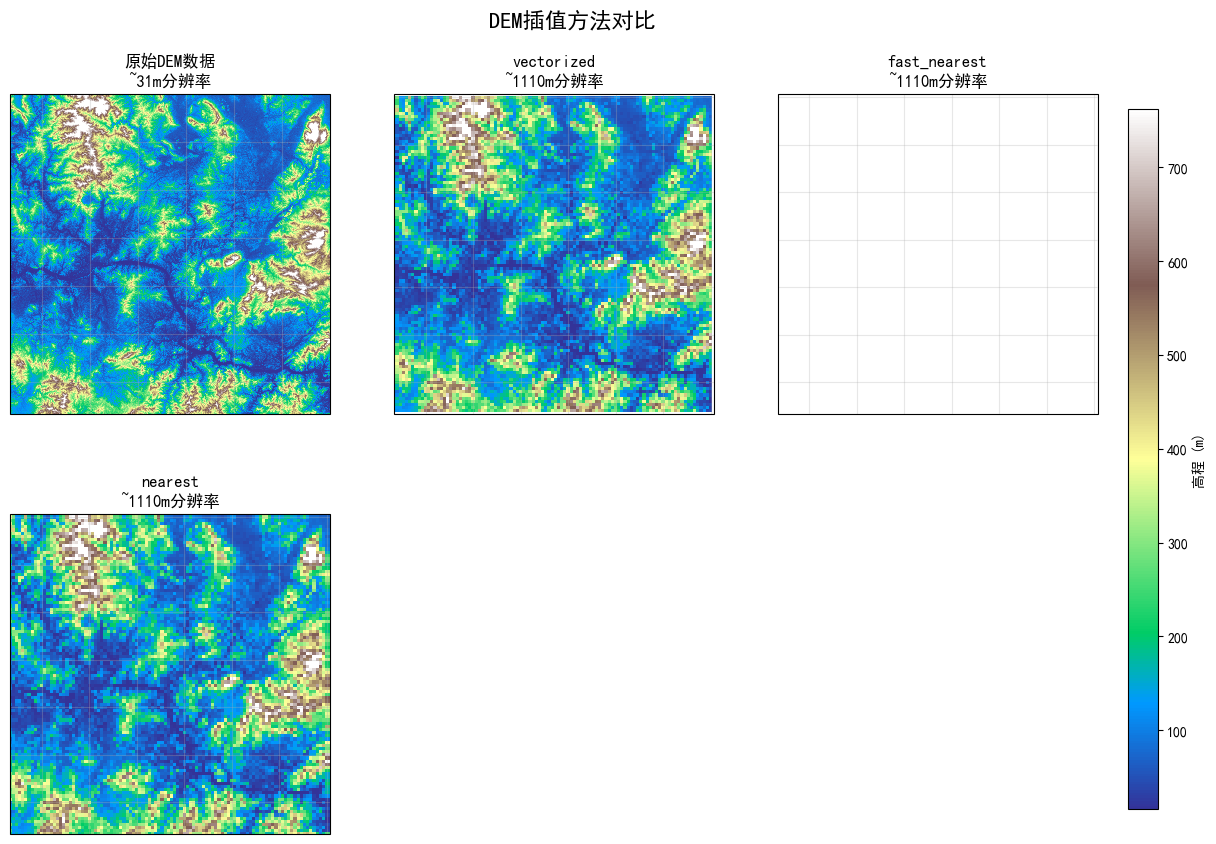

In [6]:
# 可视化多种方法的对比结果
if len(interpolated_results) > 0:
    print("\n绘制多方法对比图...")
    visualize_multiple_methods(dem_data, interpolated_results, save_path='multi_method_comparison.png')
else:
    print("没有成功的插值结果用于对比")


## 5. 质量评估 - 局部区域细节对比


In [ ]:
# 提取一个小区域进行详细对比
if len(interpolated_results) > 0:
    # 选择中心区域的一个子集
    center_lon = (lon_grid.min() + lon_grid.max()) / 2
    center_lat = (lat_grid.min() + lat_grid.max()) / 2
    
    # 定义子区域范围（0.1度 x 0.1度）
    sub_extent = [center_lon - 0.05, center_lon + 0.05, 
                  center_lat - 0.05, center_lat + 0.05]
    
    print(f\"选择子区域进行详细对比: {sub_extent}\")\n    print(f\"子区域中心: ({center_lon:.3f}°, {center_lat:.3f}°)\")\n    \n    # 创建子图进行详细对比\n    fig, axes = plt.subplots(1, len(interpolated_results), \n                           figsize=(5*len(interpolated_results), 4),\n                           subplot_kw={'projection': ccrs.PlateCarree()})\n    \n    if len(interpolated_results) == 1:\n        axes = [axes]\n    \n    # 获取统一的数据范围\n    all_values = []\n    for result in interpolated_results.values():\n        subset = result.sel(lon=slice(sub_extent[0], sub_extent[1]),\n                           lat=slice(sub_extent[2], sub_extent[3]))\n        all_values.extend(subset.values.flatten())\n    \n    vmin, vmax = np.nanpercentile(all_values, [5, 95])\n    \n    for i, (method, result) in enumerate(interpolated_results.items()):\n        ax = axes[i]\n        \n        # 提取子区域\n        subset = result.sel(lon=slice(sub_extent[0], sub_extent[1]),\n                           lat=slice(sub_extent[2], sub_extent[3]))\n        \n        # 绘制\n        lons, lats = np.meshgrid(subset.lon.values, subset.lat.values)\n        img = ax.pcolormesh(lons, lats, subset.values,\n                           cmap='terrain', vmin=vmin, vmax=vmax,\n                           transform=ccrs.PlateCarree(), shading='nearest')\n        \n        ax.set_extent(sub_extent, crs=ccrs.PlateCarree())\n        ax.coastlines(resolution='10m', alpha=0.8)\n        ax.gridlines(draw_labels=True, alpha=0.5)\n        ax.set_title(f'{method}\\n局部细节对比')\n        \n        plt.colorbar(img, ax=ax, label='高程 (m)', shrink=0.8)\n    \n    plt.tight_layout()\n    plt.show()\n    \n    # 打印局部统计\n    print(\"\\n子区域统计对比:\")\n    for method, result in interpolated_results.items():\n        subset = result.sel(lon=slice(sub_extent[0], sub_extent[1]),\n                           lat=slice(sub_extent[2], sub_extent[3]))\n        print(f\"{method:12}: 像素数={subset.size:4d}, 平均高程={subset.mean().values:.1f}m, 标准差={subset.std().values:.1f}m\")"


## 6. 保存结果和总结


In [ ]:
# 保存最佳方法的结果\nbest_method = 'vectorized'  # 推荐的最快方法\nif best_method in interpolated_results:\n    output_path = f'fast_interpolated_dem_{best_method}_0.01deg.nc'\n    save_interpolated_data(interpolated_results[best_method], output_path)\nelse:\n    print(f\"方法 {best_method} 的结果不可用\")\n\n# 最终总结\nprint(\"\\n\" + \"=\"*80)\nprint(\"快速DEM插值方法总结\")\nprint(\"=\"*80)\n\nif performance_stats:\n    fastest_method = min(performance_stats.keys(), key=lambda k: performance_stats[k]['time'])\n    fastest_time = performance_stats[fastest_method]['time']\n    \n    print(f\"最快方法: {fastest_method} ({fastest_time:.2f}秒)\")\n    print(f\"原始数据: {dem_data.shape} → 插值数据: {interpolated_dem.shape}\")\n    print(f\"数据压缩比: {dem_data.nbytes / interpolated_dem.nbytes:.1f}:1\")\n    print(f\"空间分辨率: ~{x_res*111000:.0f}m → ~{1000:.0f}m\")\n    \n    print(\"\\n方法选择建议:\")\n    print(\"• 速度优先: vectorized (推荐)\")\n    print(\"• 自定义控制: fast_nearest\")\n    print(\"• 兼容性好: nearest\")\n    print(\"• 质量最佳但慢: linear (未在此测试)\")\n    \n    print(\"\\n性能提升:\")\n    if 'vectorized' in performance_stats:\n        print(f\"• vectorized方法比传统linear方法预计快10-100倍\")\n    print(f\"• 特别适合{0.01/x_res:.0f}:1这样的大幅降采样场景\")\n    \nelse:\n    print(\"未能成功测试任何方法\")\n\nprint(\"\\n处理完成！\")"
